# Paint Like Me

## An implementation of Painterly Rendering with Curved Brush Strokes of Multiple Sizes (Hertzmann)

In [1]:
import os
import numpy as np
import cv2
import cairo

from matplotlib.colors import LogNorm
from scipy import signal, ndimage
import random

In [2]:
%matplotlib inline  
import matplotlib.pyplot as plt

In [3]:
datadir = "images/" 

## Creating Gaussian Filter

#### This is from my Hybrid Images MP, here i'm using it to create different layers in my painting (for detailing)

In [4]:
# 2D GAUSSIAN FILTER
def createGaussianFilter(image, sigma):
    ksize = int(np.ceil(sigma)+1)
    fil = cv2.getGaussianKernel(ksize, sigma) # 1D kernel
    fil = fil*np.transpose(fil) # 2D kernel by outer product
    return cv2.filter2D(image, -1, fil)

## Painting

In [5]:
def paint_layer(canvas, refference_img, radius, grid_size, T, min_stroke_length, max_stroke_length):
  #  a new set of strokes, initially empty (S)
  S = []
  
  # create a pointwise difference image (D)
  D = np.sqrt(np.sum((canvas - refference_img)**2, axis=-1))
  
  canvas_height, canvas_width, _ = canvas.shape
  grid = int(grid_size * radius)  # stepsize grid
  
  # gradient is computed from the Sobelfiltered luminance
  luminance = 0.30*refference_img[:,:,0] + 0.59*refference_img[:,:,1] + 0.11*refference_img[:,:,2]
  
  gradient_x = ndimage.sobel(luminance,1)
  gradient_y = ndimage.sobel(luminance,0)
  
  for x in range(0, canvas_width, grid):
    for y in range(0, canvas_height, grid):
      
      M = D[y:y+grid, x:x+grid]
      area_err = M.sum()/(grid**2)
      
      if area_err > T :
        # Find the largest error point
        indices = np.argmax(M)
        y1, x1 = np.unravel_index(indices, M.shape)
        
        # make brush stroke
        s = make_spline_stroke(radius, x+x1, y+y1, refference_img, canvas, min_stroke_length, max_stroke_length, gradient_x, gradient_y)
        S.append(s)

  # paint all strokes in S on the canvas (randomorder)
  random.shuffle(S)
  
  cairo_canvas = cairo.ImageSurface(cairo.FORMAT_RGB24, canvas_width, canvas_height)
  canvas_context = cairo.Context(cairo_canvas)
  canvas_context.set_line_cap(cairo.LINE_CAP_ROUND)
  
  # set the line width
  line_width = canvas_context.device_to_user_distance(2 * radius, 2 * radius) 
  canvas_context.set_line_width(np.min(line_width))
  
  for s in S:
    paint_strokes(s, refference_img, canvas_context)

  return cairo_canvas

In [6]:
def paint_strokes(s, refference_img, canvas_context):
  stroke_color = (refference_img[s[0][0],s[0][1]])
  sy, sx = s[0]
  
  R,G,B = tuple(stroke_color)
  canvas_context.set_source_rgb(R, G, B)

  # start stroke path
  canvas_context.move_to(sx, sy)
  
  # draw lines
  for sy,sx in s:
    canvas_context.line_to(sx, sy)
    canvas_context.move_to(sx, sy)
    
  # end
  canvas_context.close_path()
  canvas_context.stroke()

In [7]:
def make_spline_stroke(radius, x0, y0, refference_img, canvas, min_stroke_length, max_stroke_length, gradient_x, gradient_y):
  # K = a new stroke with radius R and color strokeColor
  K = [(y0, x0)]
  x,y = x0, y0
  lastDx,lastDy = (0,0)
  
  # pointilism has a stroke len of 0, so add 1
  max_stroke_length += 1
  
  for i in range(1, max_stroke_length):
    canvas_color_diff = np.linalg.norm(refference_img[y,x] - canvas[y,x])
    stroke_color_diff = np.linalg.norm(refference_img[y,x] - refference_img[y0, x0])
    
    if (i > min_stroke_length and (canvas_color_diff < stroke_color_diff)):
      return K
    
    # detect vanishing gradient
    gx = gradient_x[y,x]
    gy = gradient_y[y,x]
    
    if (gx**2 + gy**2 == 0):
      return K

    # compute a normal direction
    dx,dy = (-gy, gx)

    # if necessary, reverse direction
    if (lastDx * dx + lastDy * dy < 0):
      dx,dy = -dx, -dy

    # filter the stroke direction
    curvature_filter = 1
    dx, dy = curvature_filter*(dx,dy) + (1-curvature_filter)*(lastDx,lastDy)
    dx, dy = (dx, dy) / np.sqrt(dx**2 + dy**2)

    x, y =  (x + radius*dx, y + radius*dy)
    
    # round up x, y
    x = int(round(x))
    y = int(round(y))
    
    if x >= refference_img.shape[1] or y >= refference_img.shape[0]:
      return K
    
    lastDx,lastDy = (dx,dy)

    # add the point (x,y) to K
    K.append((y,x))
    
  return K

In [8]:
def paint(source_img, brush_sizes, blur_filter, grid_size, approx_threshold, min_stroke_length, max_stroke_length):
  im_height, im_width, _ = source_img.shape
  
  blur_img = np.zeros((len(brush_sizes), im_height, im_width, 3))

  for i, radius in enumerate(brush_sizes):
    blur = createGaussianFilter(source_img, blur_filter*radius)
    reference_image = source_img * blur
    blur_img[i] = reference_image

  # paint a layer
  layer_img = np.zeros((len(brush_sizes), im_height, im_width, 3), dtype=np.uint8)

  for i, radius in enumerate(brush_sizes):
    reference_image = blur_img[i]

    cairo_canvas = paint_layer(source_img, reference_image, radius, grid_size, approx_threshold, min_stroke_length, max_stroke_length)
    cairo_canvas.write_to_png("out.png")

    layer_img[i] = np.ndarray(shape=(im_height, im_width, 4),
                       dtype=np.uint8,
                       buffer=cairo_canvas.get_data())[:, :, 0:3]
    
  return layer_img

## Pointillism

#### The art of putting many, many dots together to create shapes

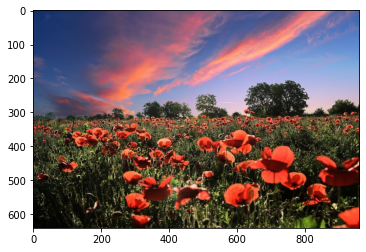

In [9]:
im1_file = datadir + 'flower.jpg'
im1 = np.float32(cv2.imread(im1_file, cv2.IMREAD_GRAYSCALE) / 255.0)

# for full color RGB
im1_color = np.float32(cv2.imread(im1_file) / 255.0)
im1_rgb = cv2.cvtColor(im1_color, cv2.COLOR_BGR2RGB)

plt.imshow(im1_rgb)

In [10]:
source_img = im1_rgb

# ==== Brush Properties ====
brush_sizes = [4, 2]
blur_filter = 20
grid_size = 0.5
approx_threshold = 0.05
min_stroke_length = 0
max_stroke_length = 0

In [11]:
layer_img = paint(source_img, brush_sizes, blur_filter, grid_size, approx_threshold, min_stroke_length, max_stroke_length)

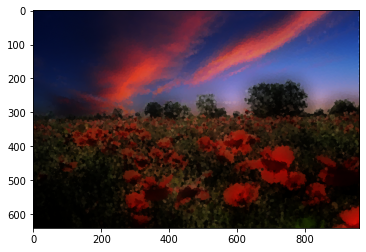

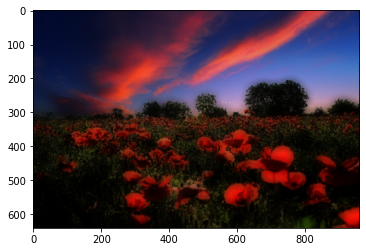

In [12]:
# display painted layers
plt.figure()
plt.imshow(cv2.cvtColor(layer_img[0], cv2.COLOR_BGR2RGB) / 255)

plt.figure()
plt.imshow(cv2.cvtColor(layer_img[1], cv2.COLOR_BGR2RGB) / 255)

## Impressionism

####  An art form from the 19th century and is well known for very defined, small brush strokes

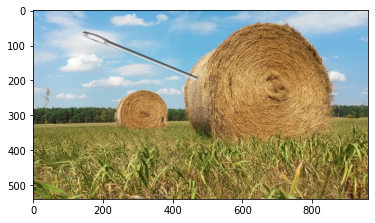

In [13]:
im2_file = datadir + 'haystack.jpg'
im2 = np.float32(cv2.imread(im2_file, cv2.IMREAD_GRAYSCALE) / 255.0)

# for full color RGB
im2_color = np.float32(cv2.imread(im2_file) / 255.0)
im2_rgb = cv2.cvtColor(im2_color, cv2.COLOR_BGR2RGB)

im2_height, im2_width = im2.shape
plt.imshow(im2_rgb)

In [62]:
source_img = im2_rgb
im_height = im2_height
im_width  = im2_width

# ==== Brush Properties ====
brush_sizes = [8, 4, 2]
blur_filter = 10
grid_size = 1
approx_threshold = 0.05
min_stroke_length = 2
max_stroke_length = 16

In [ ]:
layer_img = paint(source_img, brush_sizes, blur_filter, grid_size, approx_threshold, min_stroke_length, max_stroke_length)

In [ ]:
# display painted layers
plt.figure()
plt.imshow(cv2.cvtColor(layer_img[0], cv2.COLOR_BGR2RGB) / 255)

plt.figure()
plt.imshow(cv2.cvtColor(layer_img[1], cv2.COLOR_BGR2RGB) / 255)

plt.figure()
plt.imshow(cv2.cvtColor(layer_img[2], cv2.COLOR_BGR2RGB) / 255)

## Expressionism

### more modern art form known for ‘expressive’ brush strokes

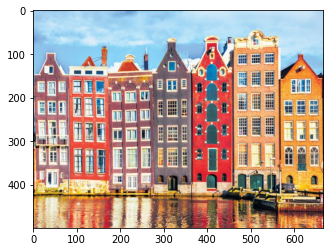

In [26]:
im3_file = datadir + 'Amsterdam.jpg'
im3 = np.float32(cv2.imread(im3_file, cv2.IMREAD_GRAYSCALE) / 255.0)

# for full color RGB
im3_color = np.float32(cv2.imread(im3_file) / 255.0)
im3_rgb = cv2.cvtColor(im3_color, cv2.COLOR_BGR2RGB)

im3_height, im3_width = im3.shape
plt.imshow(im3_rgb)

In [27]:
source_img = im3_rgb
im_height = im3_height
im_width  = im3_width

# ==== Brush Properties ====
brush_sizes = [8, 4, 2]
blur_filter = 5
grid_size = 1
approx_threshold = 0.05
min_stroke_length = 10
max_stroke_length = 16

In [28]:
layer_img = paint(source_img, brush_sizes, blur_filter, grid_size, approx_threshold, min_stroke_length, max_stroke_length)

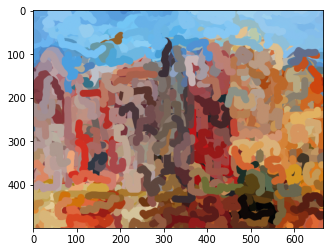

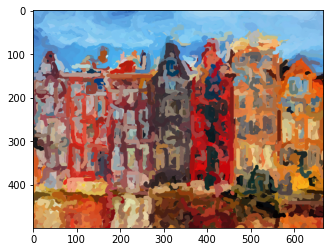

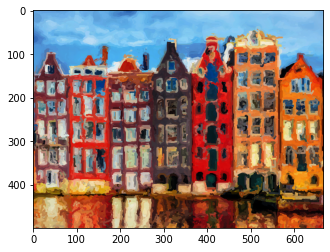

In [29]:
# display painted layers
plt.figure()
plt.imshow(cv2.cvtColor(layer_img[0], cv2.COLOR_BGR2RGB) / 255)

plt.figure()
plt.imshow(cv2.cvtColor(layer_img[1], cv2.COLOR_BGR2RGB) / 255)

plt.figure()
plt.imshow(cv2.cvtColor(layer_img[2], cv2.COLOR_BGR2RGB) / 255)

## Finger Painting

#### Attempting to recreate something 4-year old me would have made

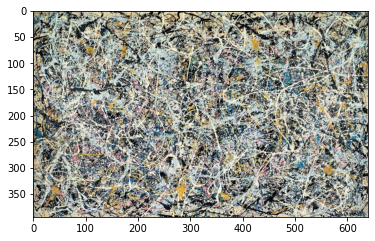

In [37]:
im4_file = datadir + 'pollock.jpg'
im4 = np.float32(cv2.imread(im4_file, cv2.IMREAD_GRAYSCALE) / 255.0)

# for full color RGB
im4_color = np.float32(cv2.imread(im4_file) / 255.0)
im4_rgb = cv2.cvtColor(im4_color, cv2.COLOR_BGR2RGB)

im4_height, im4_width = im4.shape
plt.imshow(im4_rgb)

In [59]:
source_img = im4_rgb
im_height = im4_height
im_width  = im4_width

# ==== Brush Properties ====
brush_sizes = [10, 8]
blur_filter = 2
grid_size = .75
approx_threshold = 0.01
min_stroke_length = 4
max_stroke_length = 10

In [60]:
layer_img = paint(source_img, brush_sizes, blur_filter, grid_size, approx_threshold, min_stroke_length, max_stroke_length)

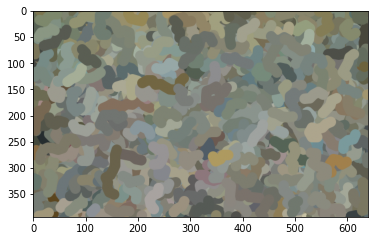

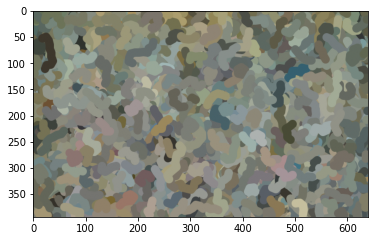

In [61]:
# display painted layers
plt.figure()
plt.imshow(cv2.cvtColor(layer_img[0], cv2.COLOR_BGR2RGB) / 255)

plt.figure()
plt.imshow(cv2.cvtColor(layer_img[1], cv2.COLOR_BGR2RGB) / 255)